To do:
* early stopper and learning rate (update)
* validation and test set



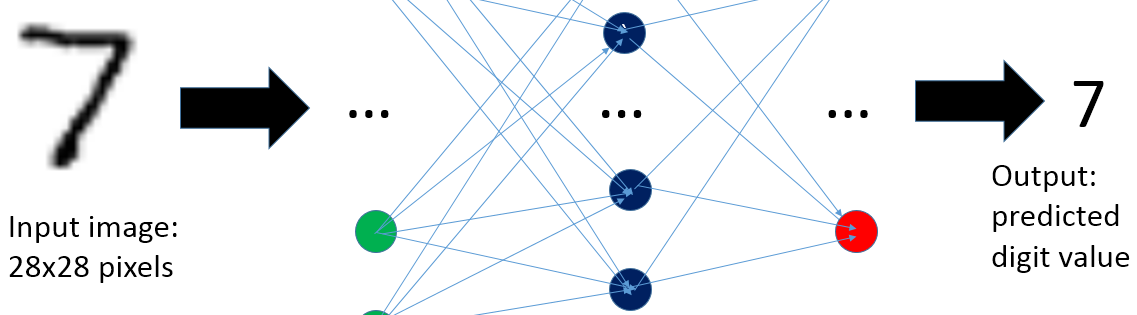

# **MNIST DIGIT RECOGNITION USING CNNs**

**This notebook is designed to read and process the MNIST dataset directly from ubyte files, visualize the data, and build a convolutional neural network (CNN) to classify handwritten digits.**
<br>
<br>
**The code for reading the dataset was adapted from Kaggle:** <br>
https://www.kaggle.com/code/hojjatk/read-mnist-dataset
<br>
<br>

---



Mount the Google Drive. <br> This allows us to access files stored in Google Drive from Colab e.g. the MNIST dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 [Link to Dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset?resource=download)<br>
 The above folder has 4 files:
*   Training Images - train-images-idx3-ubyte/train-images-idx3-ubyte
*   Training Labels - train-labels-idx1-ubyte/train-labels-idx1-ubyte
*   Test Images - t10k-images-idx3-ubyte/t10k-images-idx3-ubyte
*   Test labels - t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte
<br>
These files have been downloaded and uploaded into a drive folder named "Character Recognition"

In [ ]:
path = '/content/drive/My Drive/Character Recognition/'

training_images_filepath = path + 'train-images-idx3-ubyte/train-images-idx3-ubyte'
training_labels_filepath = path + 'train-labels-idx1-ubyte/train-labels-idx1-ubyte'
test_images_filepath = path + 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte'
test_labels_filepath = path + 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte'

# Reading the Data
**MNIST Data Loader Class:** This class handles reading the MNIST image and label files in ubyte format and returns two arrays i.e. images and labels. The images are processes into numpy arrays. It also contains a function to load training and test data.

In [ ]:
import numpy as np
import struct
from array import array

np.random.seed(42)
#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

# Data Visualization
Random samples from the training and test sets are shown here. 10 random samples from the training set and 5 random samples from the test set are selected and shown together with their labels/titles.

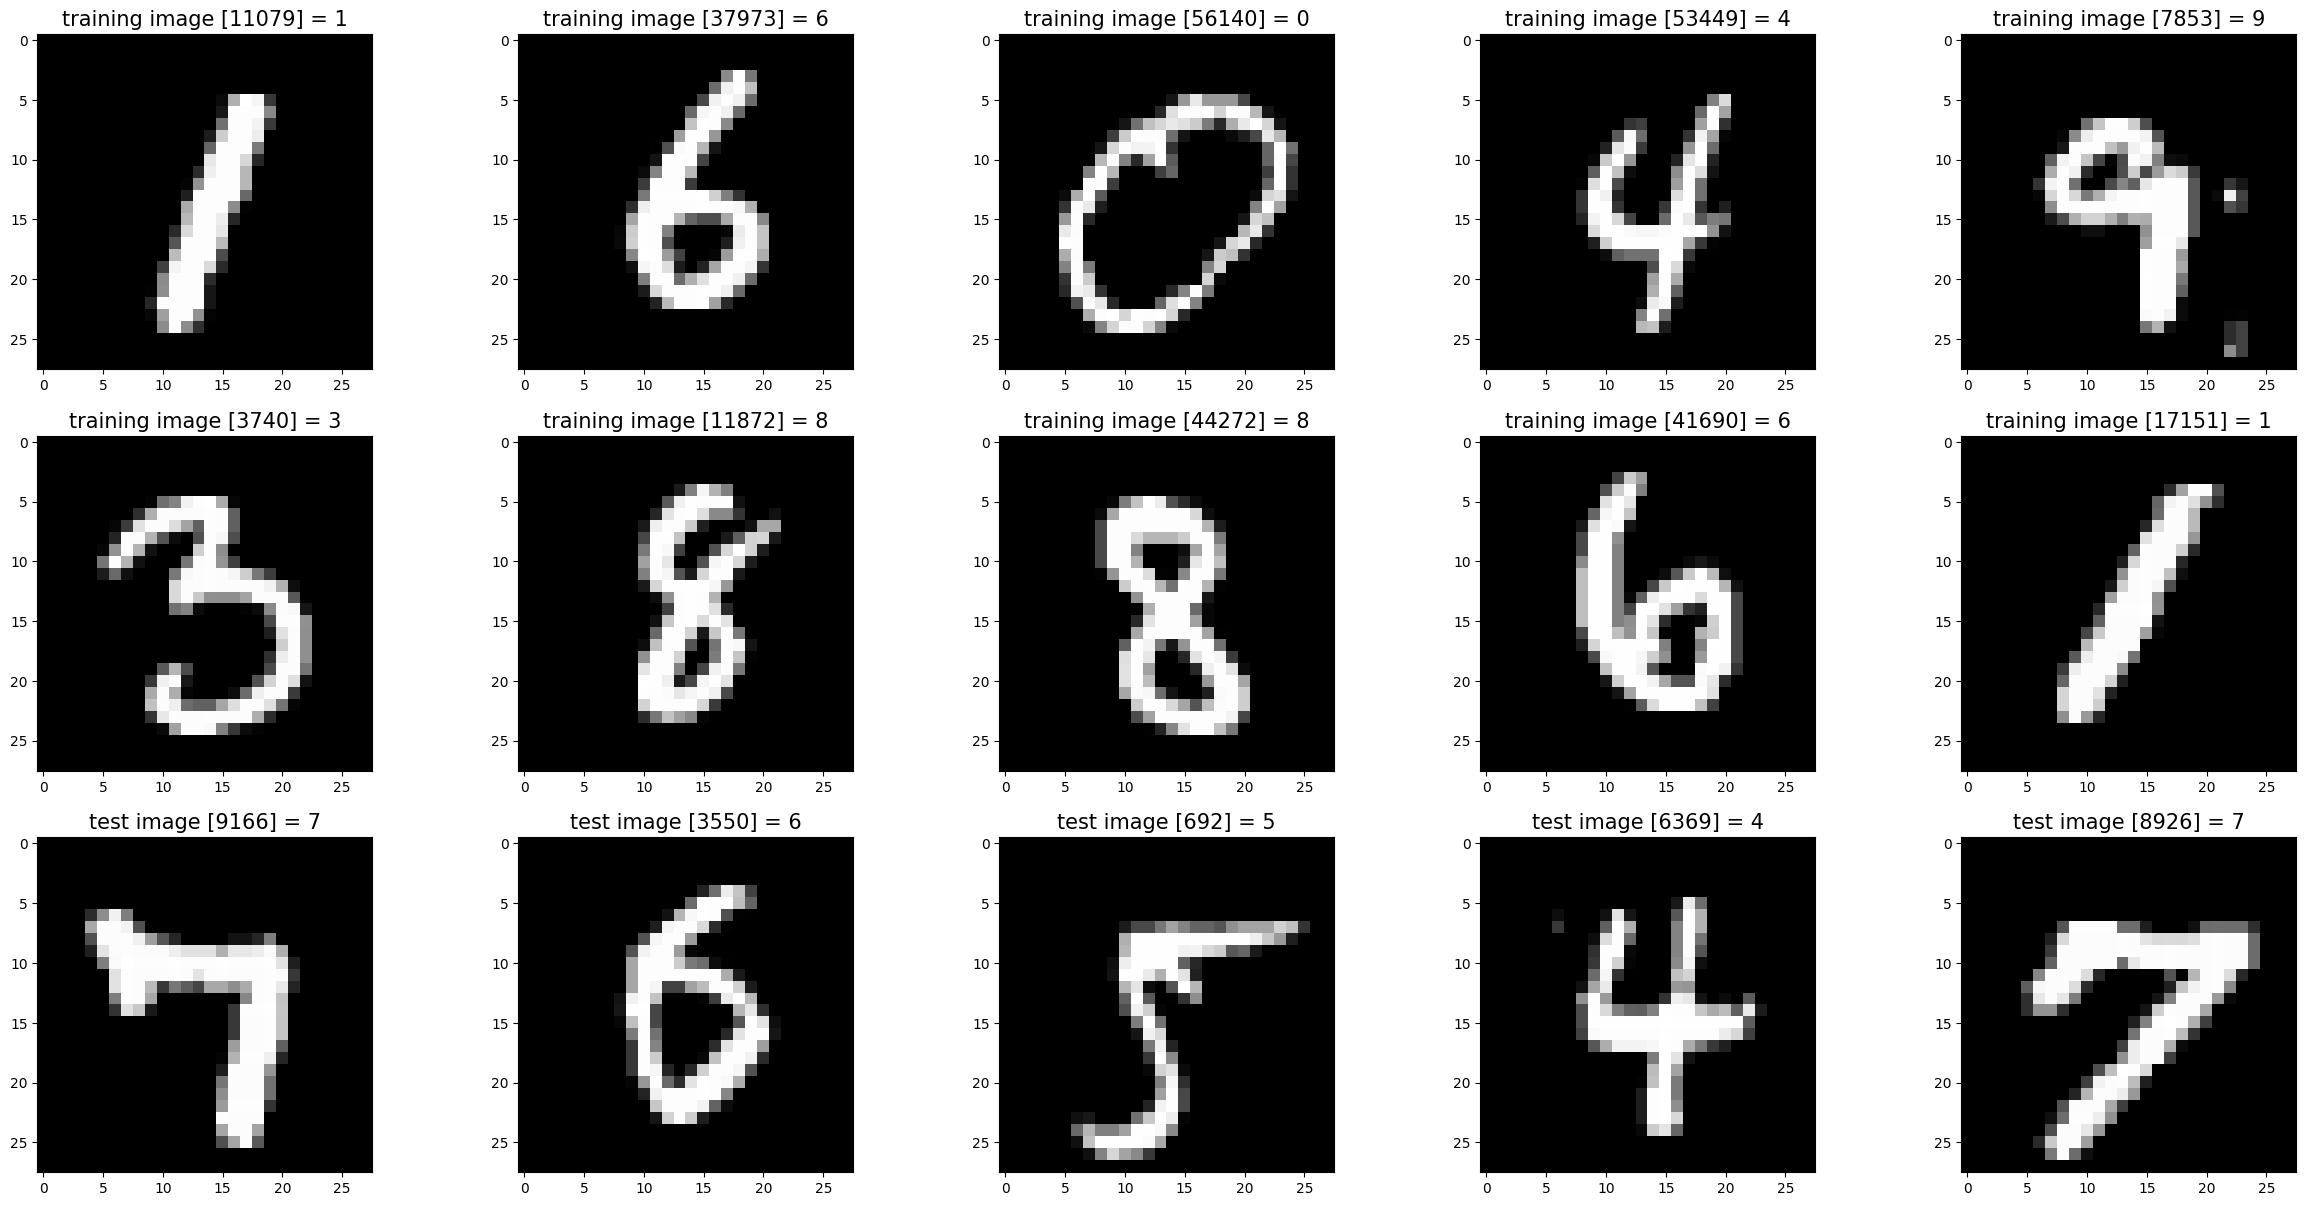

In [ ]:
%matplotlib inline
import random
import matplotlib.pyplot as plt
#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))

show_images(images_2_show, titles_2_show)

# Import necessary libraries for building & evaluating the neural network

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
from sklearn.model_selection import train_test_split # Because we will split the training data into a training set and a validation set.
from sklearn.metrics import confusion_matrix # Usefull at the end to see where the model makes mistakes
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

# Data Preprocessing

In [ ]:
# Convert lists to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

Normalize image pixel values to the range [0, 1].

In [ ]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

Reshape the image data to be compatible with CNN input requirement

In [ ]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

This will apply random transformations to the input images during training effectively giving us more training examples by artificially expanding the dataset. <br> Four techniques are used i.e.


*   RandomRotation(0.1): Rotates the image by up to 10%.
*   RandomZoom(0.1): Zooms in or out by up to 10%.
*   RandomTranslation(0.1, 0.1): Shifts the image up to 10% vertically and horizontally.





In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
])

# Model Architecture

This model classification accepts 28x28 grayscale images as input (28,28,1).  
The model consists of two convolutional layers (64 and 128 filters) with ReLU activation, each followed by Batch Normalization and MaxPooling to improve feature learning and reduce dimensionality.  
This is followed by a Flatten layer then a fully connected layer. This is one dense layer with 256 neurons and  a dropout of 40% to prevent overfitting. <br>
The final output layer uses softmax activation to convert the output into probabilities and classifies into one of 10 categories.

In [ ]:
model = keras.Sequential([
    keras.Input(shape=(28, 28, 1)),
    data_augmentation,  # Augment during training

    layers.Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    #layers.Dropout(0.2),

    #layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    #layers.BatchNormalization(),
    #layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),

    layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 10, 10, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10, 10, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 898,314 (3.43 MB)

 Trainable params: 897,930 (3.43 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

The early_stopper prevents overfitting by stopping the training if the model's performance on validation data doesn't improve after a few epochs (in this case 4 epochs).

In [ ]:
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

The learning rate scheduler reduces the learning rate by a factor of 0.5 if no improvement is seen after 3 epochs (improvememnt is measured by monitoring the validation loss). This helps the model escape local minima, ensuring better convergence.

In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-5
)

In [ ]:
# Ensure labels are arrays
y_train = y_train.astype("int32")
y_test = y_test.astype("int32")

# Training

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        x_train, y_train,
        epochs=50,
        batch_size=64,
        validation_data=(x_test, y_test),
        callbacks=[early_stopper, lr_scheduler]
    )

Epoch 1/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.6576 - loss: 1.1058 - val_accuracy: 0.9427 - val_loss: 0.1813 - learning_rate: 0.0010
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8997 - loss: 0.3274 - val_accuracy: 0.9672 - val_loss: 0.0997 - learning_rate: 0.0010
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9249 - loss: 0.2492 - val_accuracy: 0.9623 - val_loss: 0.1313 - learning_rate: 0.0010
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9357 - loss: 0.2103 - val_accuracy: 0.9745 - val_loss: 0.0790 - learning_rate: 0.0010
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9406 - loss: 0.1927 - val_accuracy: 0.9739 - val_loss: 0.0899 - learning_rate: 0.0010
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9451 - loss: 0.1804 - val_accuracy: 0.9724 - val_loss: 0.0905 - learning_rate: 0.0010
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9491 - los

In [ ]:
'''history = model.fit(
    x_train, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(x_test, y_test),
    callbacks=[early_stopper]
)'''

# Evaluation

This model achieves an accuracy of approximately 97.45%

In [ ]:
# Evaluate the model
model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9681 - loss: 0.0915


[0.07899671792984009, 0.9745000004768372]

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 10, 10, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10, 10, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,694,176 (10.28 MB)

 Trainable params: 897,930 (3.43 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 1,795,862 (6.85 MB)

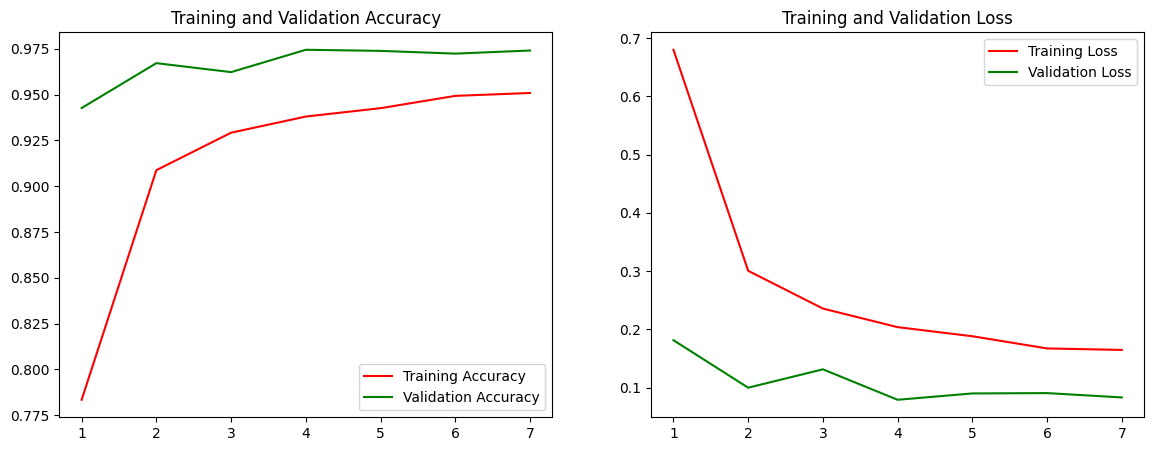

In [ ]:
# Plot accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot Training and Validation Accuracy
ax[0].plot(epochs, acc, 'r-', label='Training Accuracy')  # Red line for training
ax[0].plot(epochs, val_acc, 'g-', label='Validation Accuracy')  # Green line for validation
ax[0].set_title('Training and Validation Accuracy')
ax[0].legend()

# Plot Training and Validation Loss
ax[1].plot(epochs, loss, 'r-', label='Training Loss')  # Red line for training
ax[1].plot(epochs, val_loss, 'g-', label='Validation Loss')  # Green line for validation
ax[1].set_title('Training and Validation Loss')
ax[1].legend()

plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


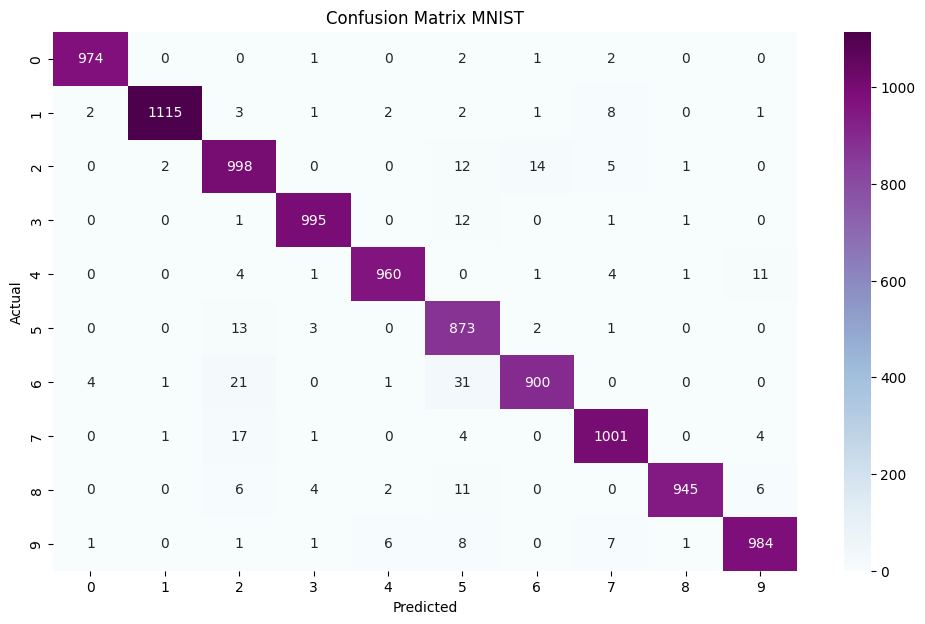

In [ ]:
# Make predictions on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title('Confusion Matrix MNIST')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.98      0.99      1135
           2       0.94      0.97      0.95      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.98      0.98       982
           5       0.91      0.98      0.95       892
           6       0.98      0.94      0.96       958
           7       0.97      0.97      0.97      1028
           8       1.00      0.97      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.98      0.97      0.97     10000



In [ ]:
# Save the model
model.save('/content/drive/MyDrive/mnist_model.keras')